# Introduction to Neural Networks 
Author: Bethany Lusch, adapting materials from Marieme Ngom, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset. 

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="images/mnist_task.png"  align="left"/>



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

import IPython.display as ipydis

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example 

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [3]:
training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

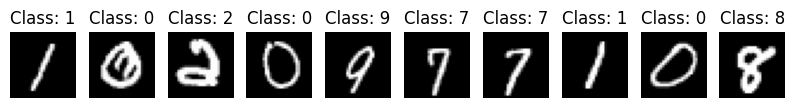

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

In [22]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week. 
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication. 

Note, like before, we consider multiple examples at once, adding another dimension to the input. 


 <img src="images/LinearModel_1.png"  align="center"/>
 


The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. 

We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

Let's make two changes that make more sense for classification:
- Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
- Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/). 

In [7]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        # First, we need to convert the input image to a vector by using 
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()
        
        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes 
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)
        
    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this time we're switching to cross entropy since it's classification.  

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step. 

In [8]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.01)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [11]:
%%time

epochs = 5
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.9104752076466879, accuracy: 83.42708333333333
Epoch 1: training loss: 0.681213703473409, accuracy: 85.48333333333333
Epoch 2: training loss: 0.5878367065588633, accuracy: 86.44583333333333
Epoch 3: training loss: 0.5354010832309722, accuracy: 87.16458333333334
Epoch 4: training loss: 0.5010628049373627, accuracy: 87.69375000000001
CPU times: user 17min 23s, sys: 22.1 s, total: 17min 45s
Wall time: 33.9 s


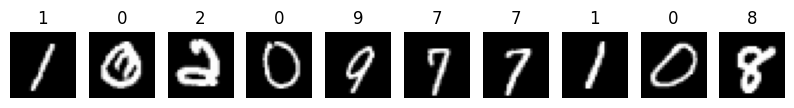

In [12]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc. 

In [13]:
%%time

linear_model = LinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.01)

epochs = 5
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.2888032813469569, accuracy: 91.94375000000001
Epoch 1: training loss: 0.2721187952160835, accuracy: 92.45416666666667
Epoch 2: training loss: 0.26440438387791315, accuracy: 92.65625
Epoch 3: training loss: 0.25955385726690294, accuracy: 92.80625
Epoch 4: training loss: 0.25602033179998396, accuracy: 92.9125
CPU times: user 17min 23s, sys: 21.8 s, total: 17min 45s
Wall time: 33.3 s


# Inference

For a better measure of the quality of the model, let's see the model accuracy for the validation data.



In [14]:
acc_val, loss_val = evaluate(val_dataloader, linear_model, loss_fn)
print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Validation loss: 0.2859, validation accuracy: 92.13%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [15]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the validation data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


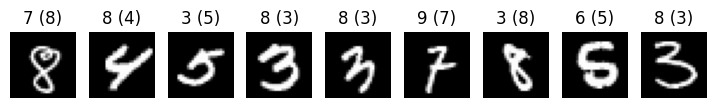

In [16]:
show_failures(linear_model, val_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="images/shallow_nn.png"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="images/activation.jpeg"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="images/deep_nn.png"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="images/bias_vs_variance.png"  align="left"/>

To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [17]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

# Homework: train a Nonlinear Classifier

1. Write some code to train the NonlinearClassifier.
2. Create a data loader for the test data and check your model's accuracy on the test data. 

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization. 

# Submission

## Part 1 and 2

The goal of this exercise is to train a non-linear neural network. We'll write some code to create a non-linear classifier, then train the model.

### MyNonLinearClassifier

For the non-linear classifier, we will use several layers of "hidden nodes" that use ReLU activation functions. We include some dropout layers in order to reduce over-fitting.

In [20]:
class MyNonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

### Training and Validating the Model

One of the topics I wanted to understand really well as part of this course is how to avoid over-fitting and when to know when to stop training. The concept of a train/validation/test split in the data was new to me, but makes sense as a way to understand when to stop training. In the next cell, we train out non-linear classifier from above, with a validation check every 5 epoch passes. We use this check to validate how our model is against data it hasn't seen. This will give a clue to indicate when to stop training our model.

Epoch 0: training loss: 0.25094993704557417, accuracy: 92.51666666666667
Validation loss: 0.2595, validation accuracy: 92.27%


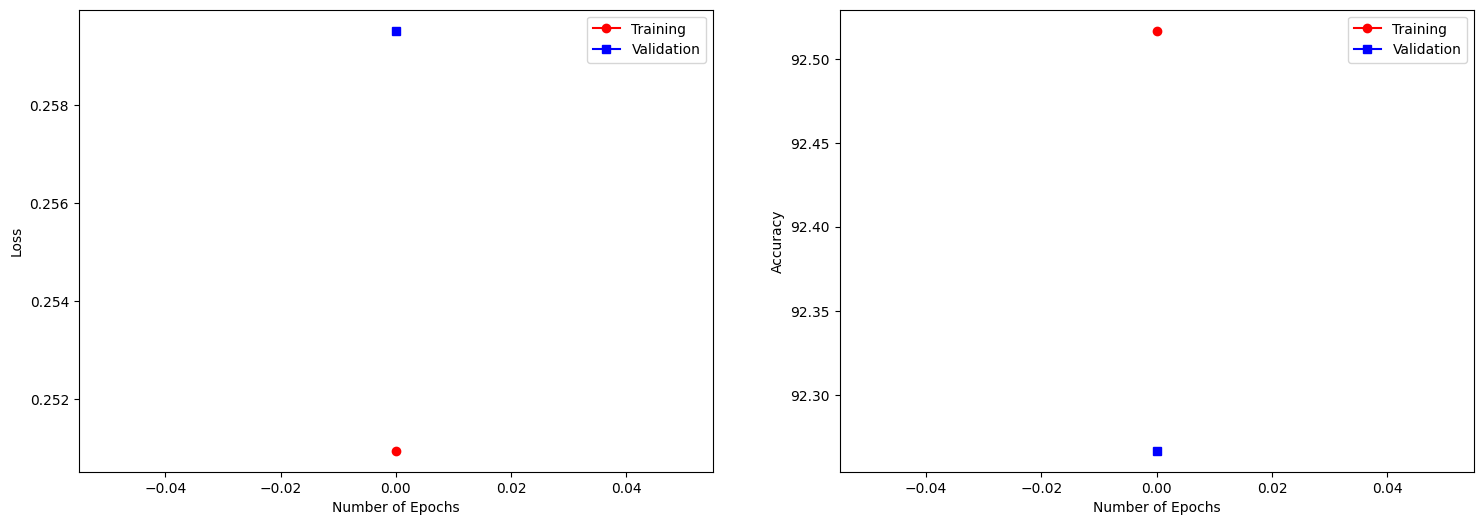

Epoch 1: training loss: 0.2240315690835317, accuracy: 93.40416666666667
Epoch 2: training loss: 0.19521647043029466, accuracy: 94.5
Epoch 3: training loss: 0.18192388588190078, accuracy: 94.64166666666667
Epoch 4: training loss: 0.1901902642250061, accuracy: 94.61041666666667
Epoch 5: training loss: 0.17527923053503036, accuracy: 94.74583333333332
Validation loss: 0.2022, validation accuracy: 94.08%


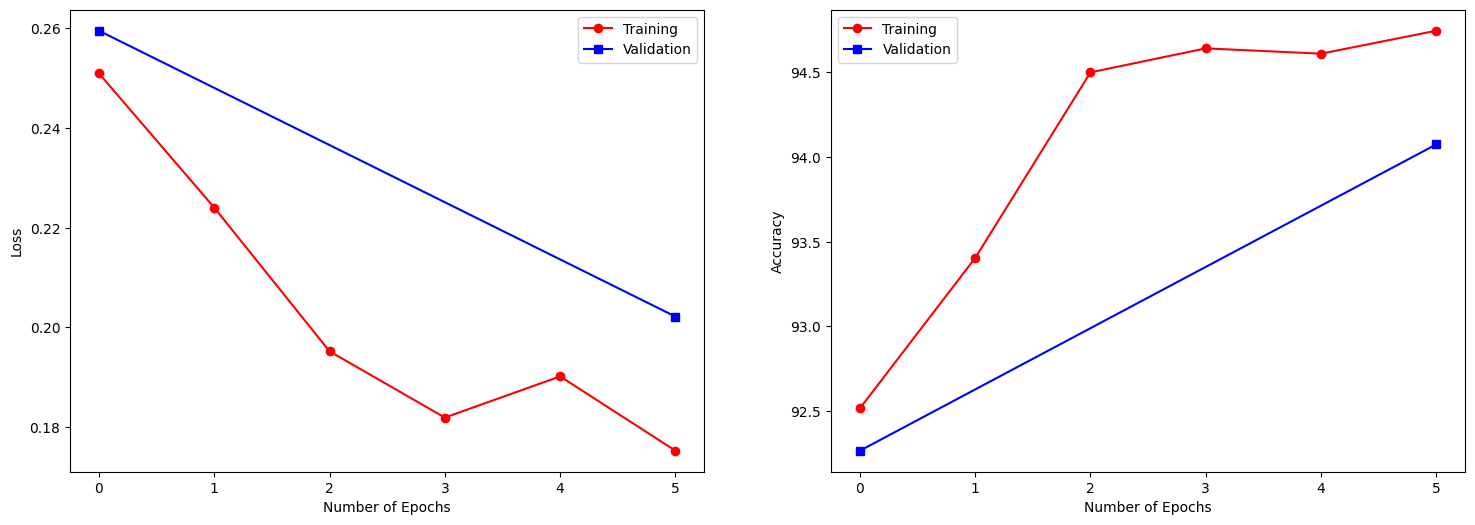

Epoch 6: training loss: 0.16435277159015338, accuracy: 95.04166666666667
Epoch 7: training loss: 0.16440489956736565, accuracy: 95.17291666666667
Epoch 8: training loss: 0.16911507881681123, accuracy: 94.95625
Epoch 9: training loss: 0.16165080197652182, accuracy: 95.16250000000001
Epoch 10: training loss: 0.15467874203125637, accuracy: 95.5375
Validation loss: 0.1905, validation accuracy: 94.62%


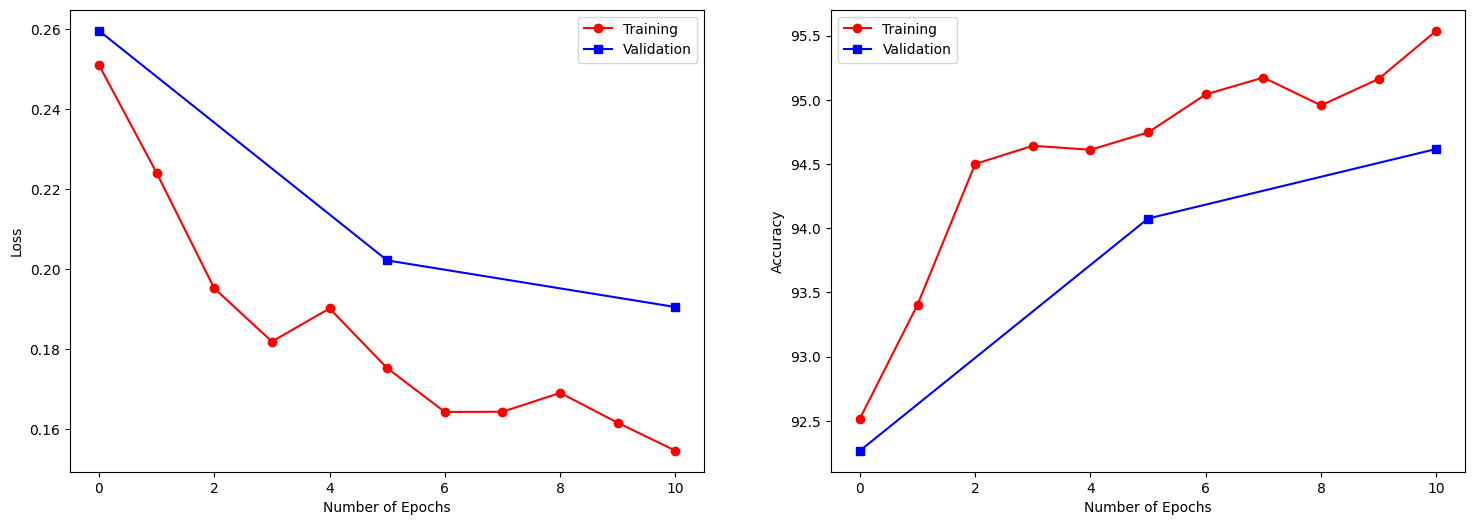

Epoch 11: training loss: 0.15426361784338952, accuracy: 95.39583333333333
Epoch 12: training loss: 0.14942213650544484, accuracy: 95.50625000000001
Epoch 13: training loss: 0.16375679871439933, accuracy: 95.18958333333333
Epoch 14: training loss: 0.14079324332873028, accuracy: 95.83541666666666
Epoch 15: training loss: 0.14315142541130385, accuracy: 95.79791666666667
Validation loss: 0.1897, validation accuracy: 94.55%


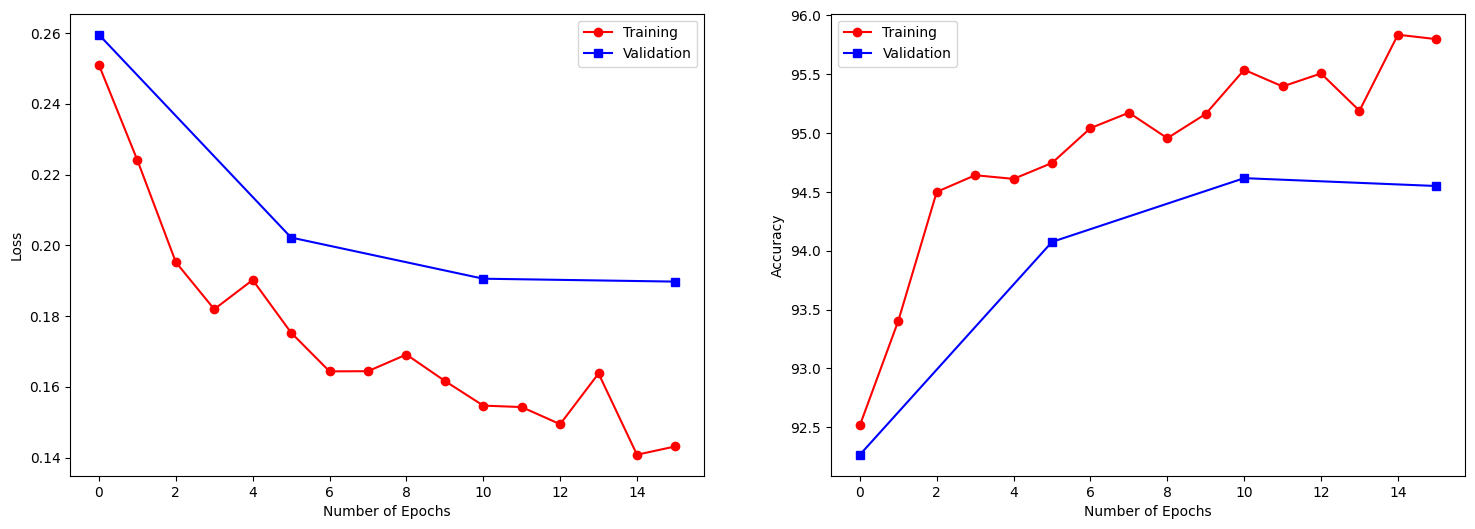

Epoch 16: training loss: 0.14632742885748545, accuracy: 95.62083333333334
Epoch 17: training loss: 0.1432033218840758, accuracy: 95.66666666666667
Epoch 18: training loss: 0.15421863976120948, accuracy: 95.31041666666667
Epoch 19: training loss: 0.14094968655705453, accuracy: 95.86041666666667
Epoch 20: training loss: 0.13127654433250427, accuracy: 96.13541666666666
Validation loss: 0.1840, validation accuracy: 95.11%


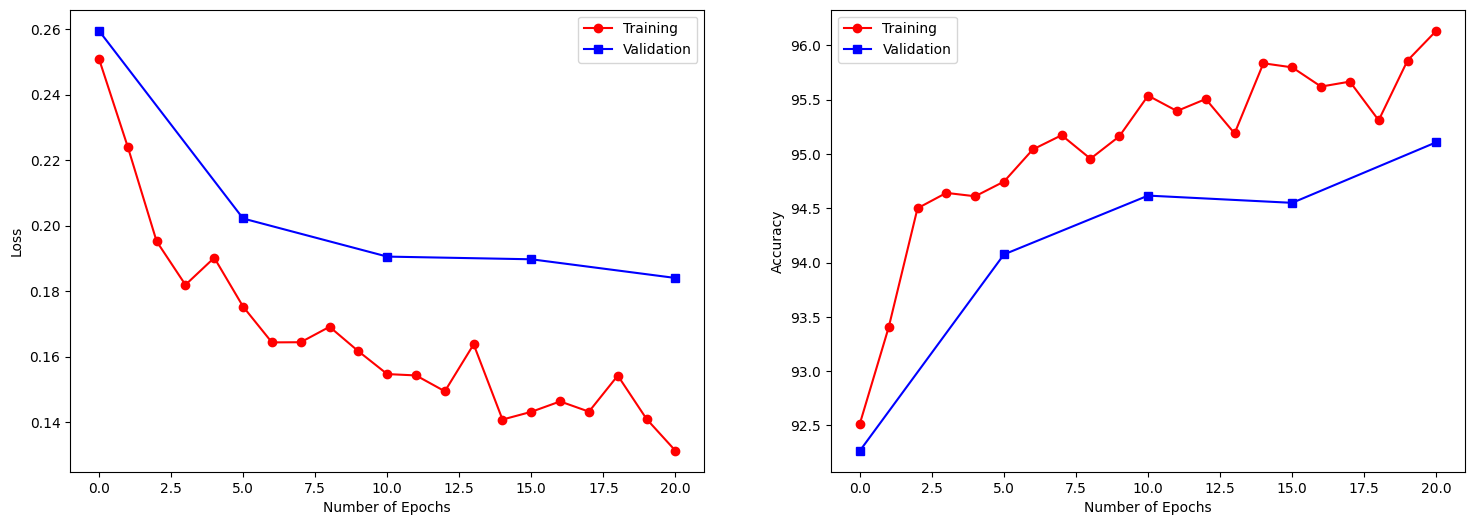

Epoch 21: training loss: 0.15179321717222533, accuracy: 95.5125
Epoch 22: training loss: 0.1582672747373581, accuracy: 95.36041666666667
Epoch 23: training loss: 0.13023864948749542, accuracy: 96.2125
Epoch 24: training loss: 0.15276374112566313, accuracy: 95.44375000000001
Epoch 25: training loss: 0.1473745191891988, accuracy: 95.47291666666666
Validation loss: 0.2020, validation accuracy: 94.47%


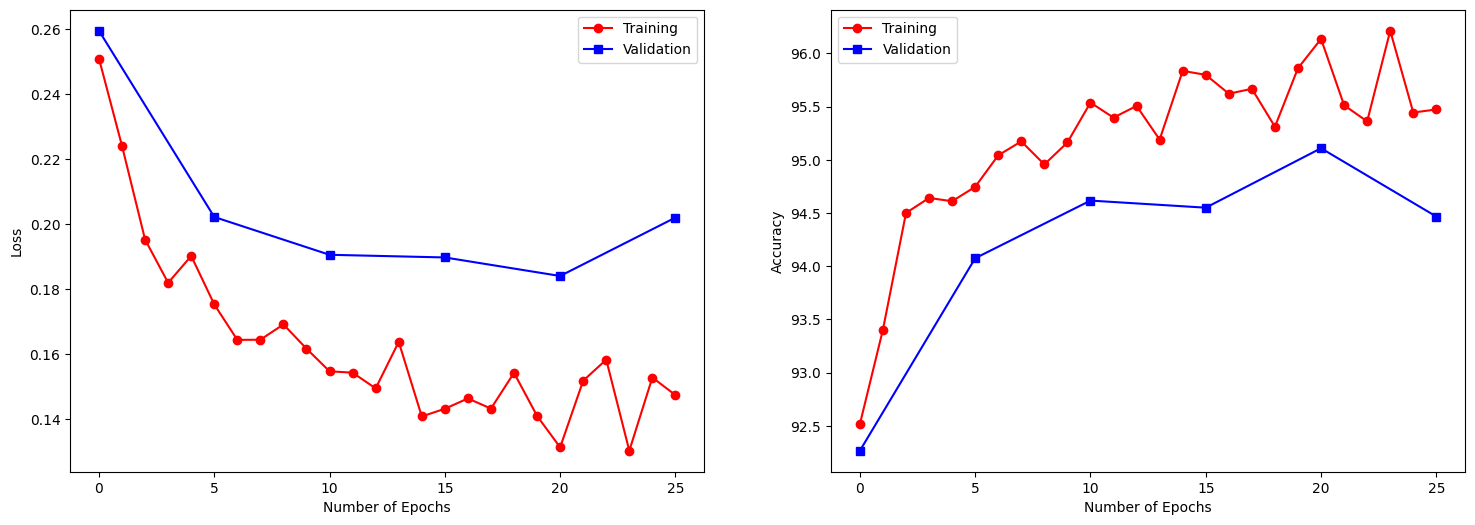

Epoch 26: training loss: 0.150199946085612, accuracy: 95.40208333333334
Epoch 27: training loss: 0.13834973222513994, accuracy: 95.9375
Epoch 28: training loss: 0.1320498901208242, accuracy: 96.06875000000001
Epoch 29: training loss: 0.13608076201876004, accuracy: 95.72708333333333
Epoch 30: training loss: 0.14019682568311692, accuracy: 96.05208333333334
Validation loss: 0.1935, validation accuracy: 94.94%


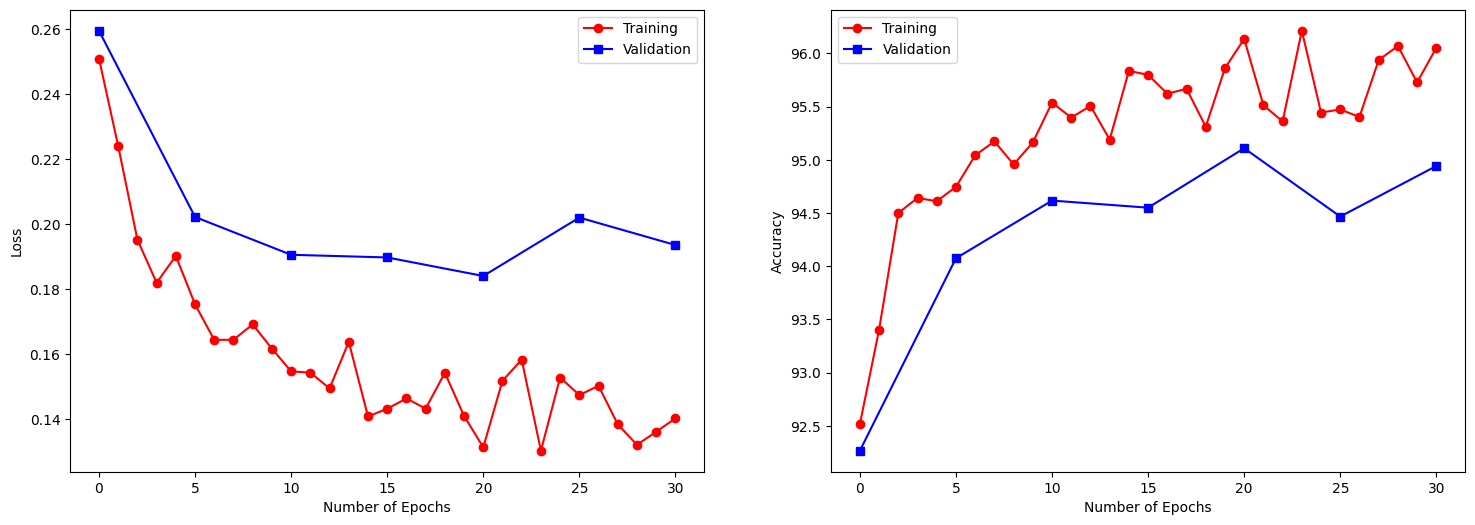

Epoch 31: training loss: 0.14151459755500156, accuracy: 95.67916666666667
Epoch 32: training loss: 0.14016048618157706, accuracy: 95.92083333333333
Epoch 33: training loss: 0.15096274336179097, accuracy: 95.16666666666667
Epoch 34: training loss: 0.12073631983995438, accuracy: 96.39791666666667
Epoch 35: training loss: 0.14293160070975622, accuracy: 95.78541666666666
Validation loss: 0.2028, validation accuracy: 94.60%


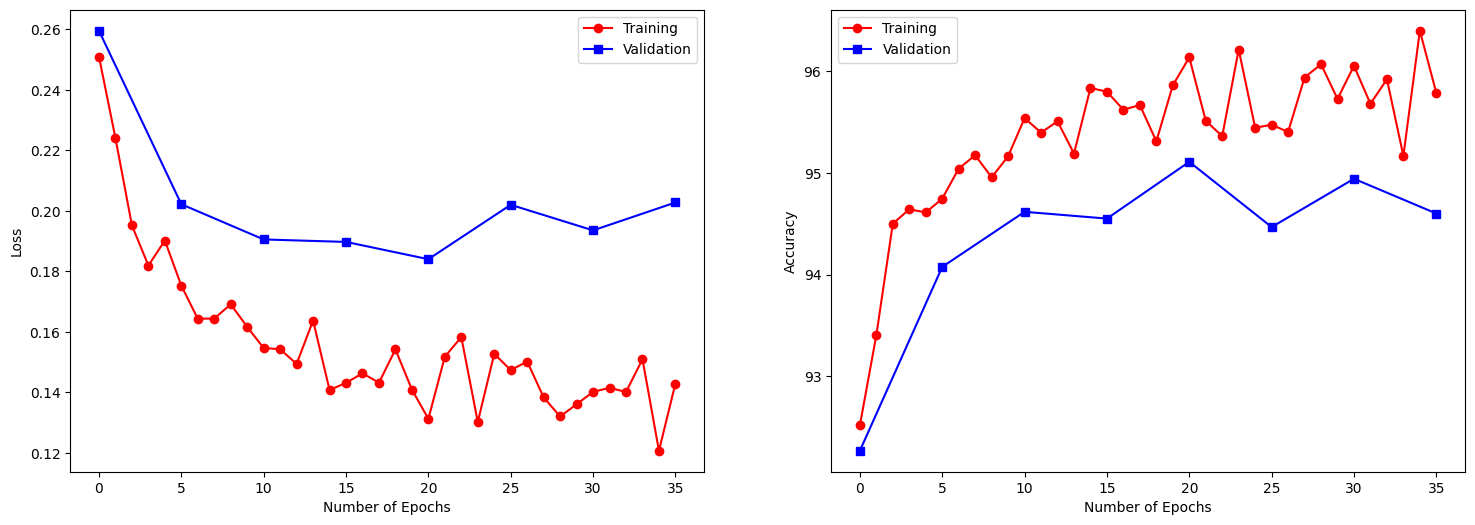

Epoch 36: training loss: 0.1343372786740462, accuracy: 96.07291666666666
Epoch 37: training loss: 0.13427745409806568, accuracy: 95.83749999999999
Epoch 38: training loss: 0.1325002131263415, accuracy: 96.21875
Epoch 39: training loss: 0.12928286130229633, accuracy: 96.04791666666667
Epoch 40: training loss: 0.13586052802205087, accuracy: 96.03541666666666
Validation loss: 0.1984, validation accuracy: 94.82%


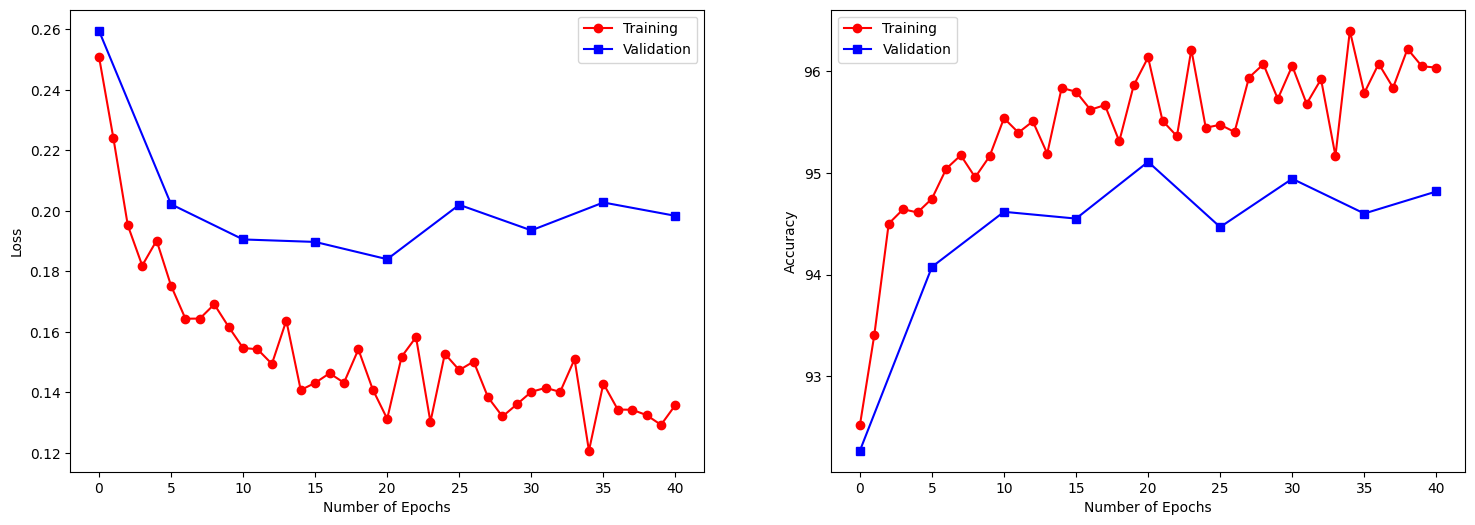

Epoch 41: training loss: 0.12359989962478479, accuracy: 96.35208333333334
Epoch 42: training loss: 0.1464914742509524, accuracy: 95.70833333333333
Epoch 43: training loss: 0.1288559521138668, accuracy: 96.25625
Epoch 44: training loss: 0.13914923299352328, accuracy: 95.66041666666666
Epoch 45: training loss: 0.12892249580224355, accuracy: 96.22708333333333
Validation loss: 0.1931, validation accuracy: 94.90%


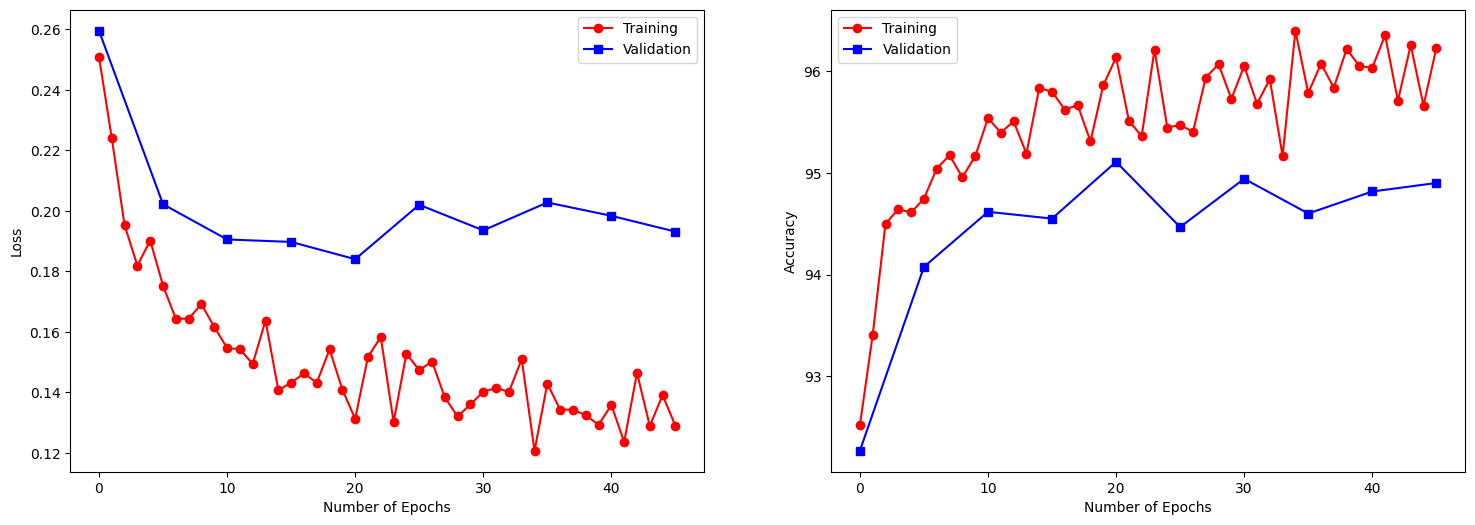

Epoch 46: training loss: 0.13028898977239928, accuracy: 96.1625
Epoch 47: training loss: 0.1279406645298004, accuracy: 96.29583333333333
Epoch 48: training loss: 0.12270711678266526, accuracy: 96.30833333333332
Epoch 49: training loss: 0.13136025743186475, accuracy: 96.08333333333333
Epoch 50: training loss: 0.12462325052917003, accuracy: 96.15416666666667
Validation loss: 0.1973, validation accuracy: 94.73%


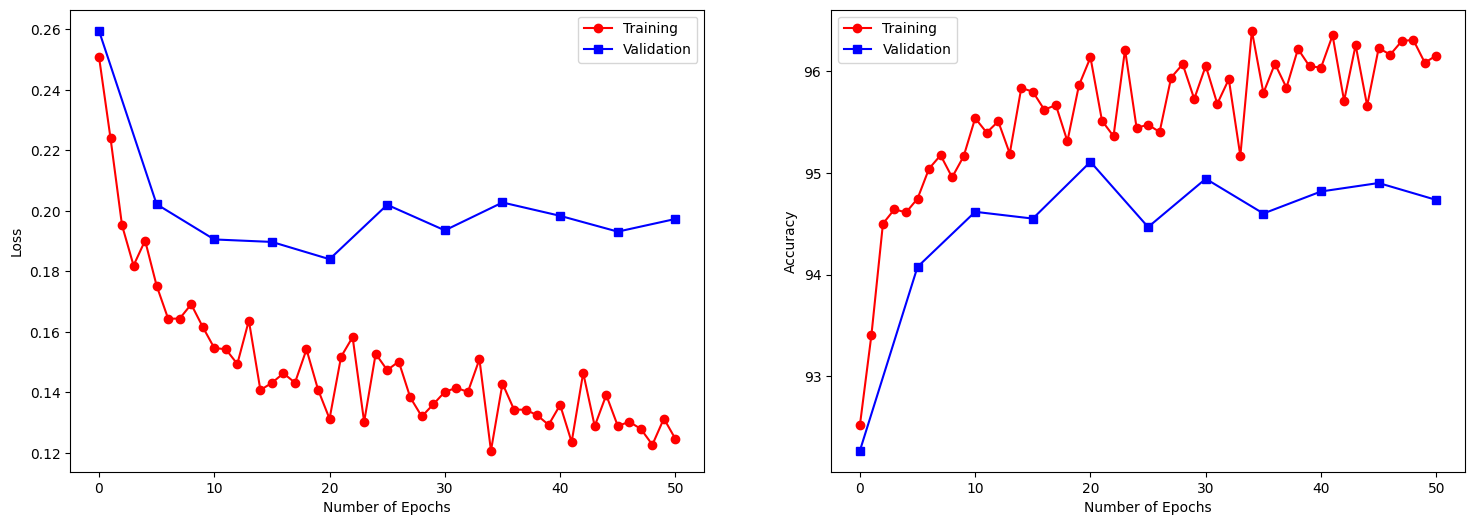

Epoch 51: training loss: 0.13599780895312627, accuracy: 96.02291666666667
Epoch 52: training loss: 0.12570139651497206, accuracy: 96.25625
Epoch 53: training loss: 0.13433411780993143, accuracy: 96.18541666666667
Epoch 54: training loss: 0.12553325879573823, accuracy: 96.15833333333333
Epoch 55: training loss: 0.1274696276684602, accuracy: 96.26041666666667
Validation loss: 0.2009, validation accuracy: 95.23%


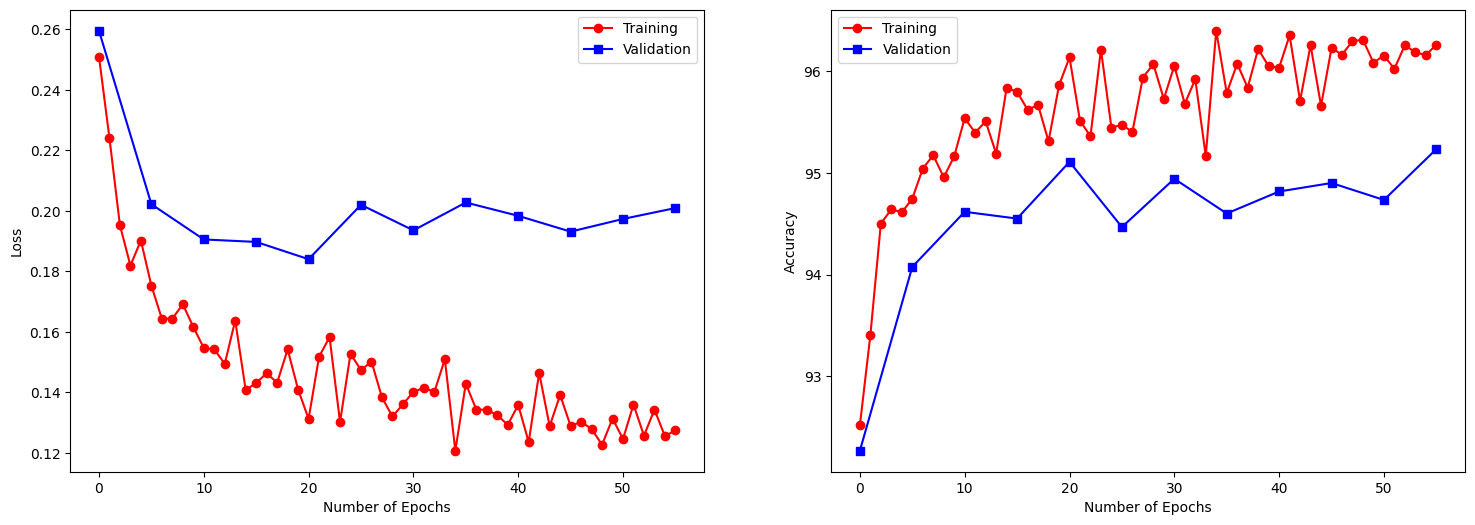

Epoch 56: training loss: 0.11753305252889792, accuracy: 96.5125
Epoch 57: training loss: 0.12185653761029243, accuracy: 96.47291666666666
Epoch 58: training loss: 0.134142461925745, accuracy: 96.10416666666667
Epoch 59: training loss: 0.1262733856936296, accuracy: 96.28125
Epoch 60: training loss: 0.12321697503825028, accuracy: 96.39166666666667
Validation loss: 0.2001, validation accuracy: 94.98%


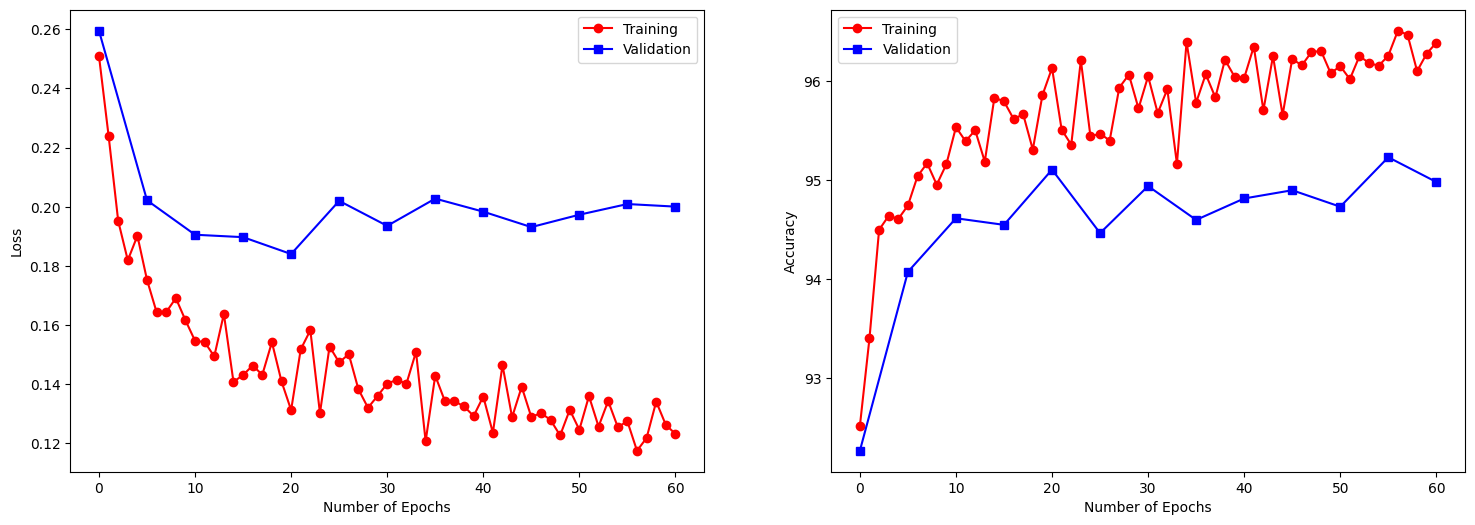

Epoch 61: training loss: 0.12241782293717067, accuracy: 96.34791666666666
Epoch 62: training loss: 0.11934791992108028, accuracy: 96.52291666666667
Epoch 63: training loss: 0.11742953756451607, accuracy: 96.58541666666667
Epoch 64: training loss: 0.11505981081227462, accuracy: 96.64375
Epoch 65: training loss: 0.12306681075692177, accuracy: 96.30625
Validation loss: 0.2086, validation accuracy: 94.83%


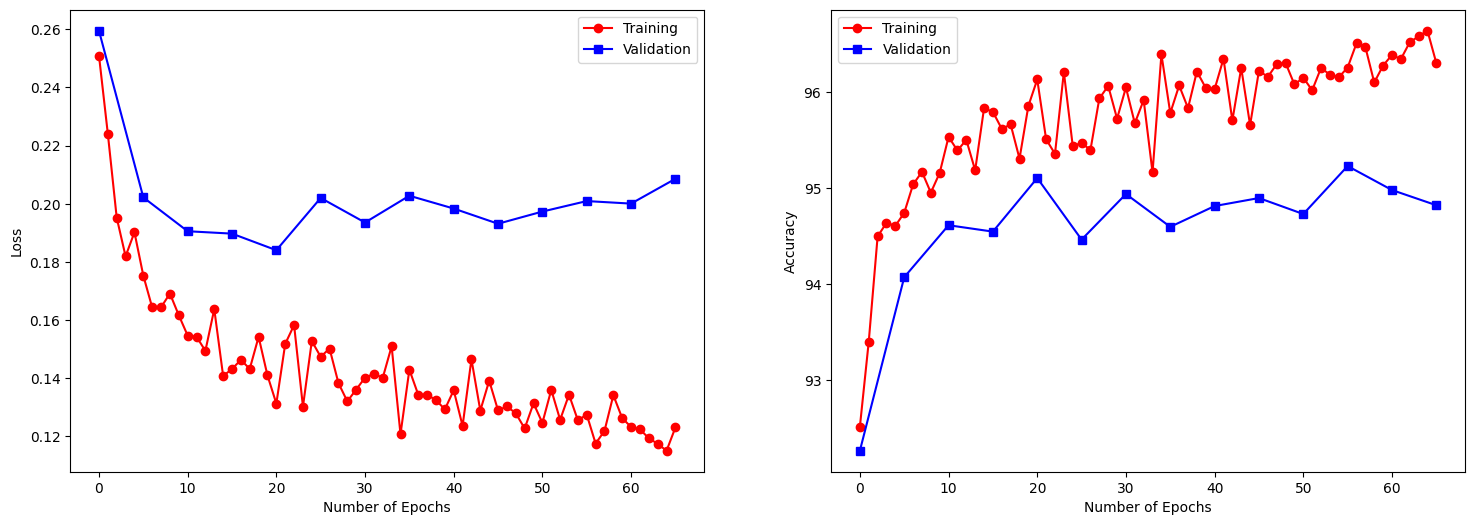

Epoch 66: training loss: 0.13311369773248832, accuracy: 96.09791666666668
Epoch 67: training loss: 0.12227998441457748, accuracy: 96.44583333333333
Epoch 68: training loss: 0.12261812557280063, accuracy: 96.42500000000001
Epoch 69: training loss: 0.12578638661901156, accuracy: 96.30833333333332
Epoch 70: training loss: 0.1307277850061655, accuracy: 96.32708333333333
Validation loss: 0.2164, validation accuracy: 94.69%


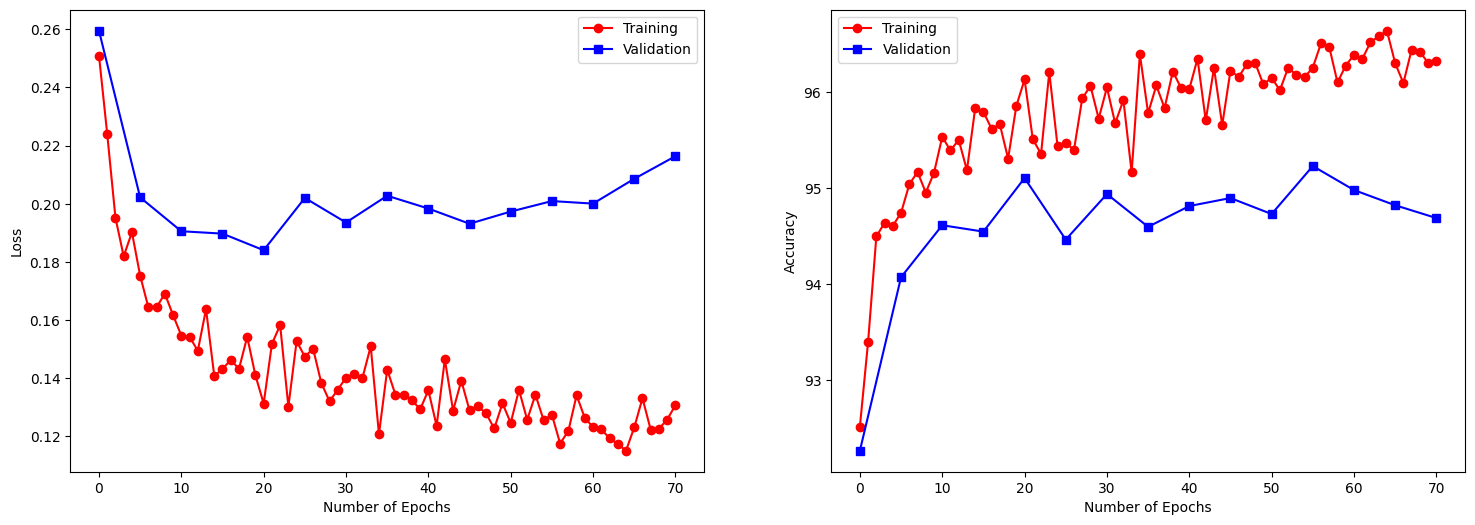

Epoch 71: training loss: 0.12831543332835038, accuracy: 96.1
Epoch 72: training loss: 0.11832317215204238, accuracy: 96.58958333333332
Epoch 73: training loss: 0.11228042646249135, accuracy: 96.66041666666668
Epoch 74: training loss: 0.1279887421776851, accuracy: 96.37916666666668
Epoch 75: training loss: 0.13538489232460657, accuracy: 96.0875
Validation loss: 0.2222, validation accuracy: 94.97%


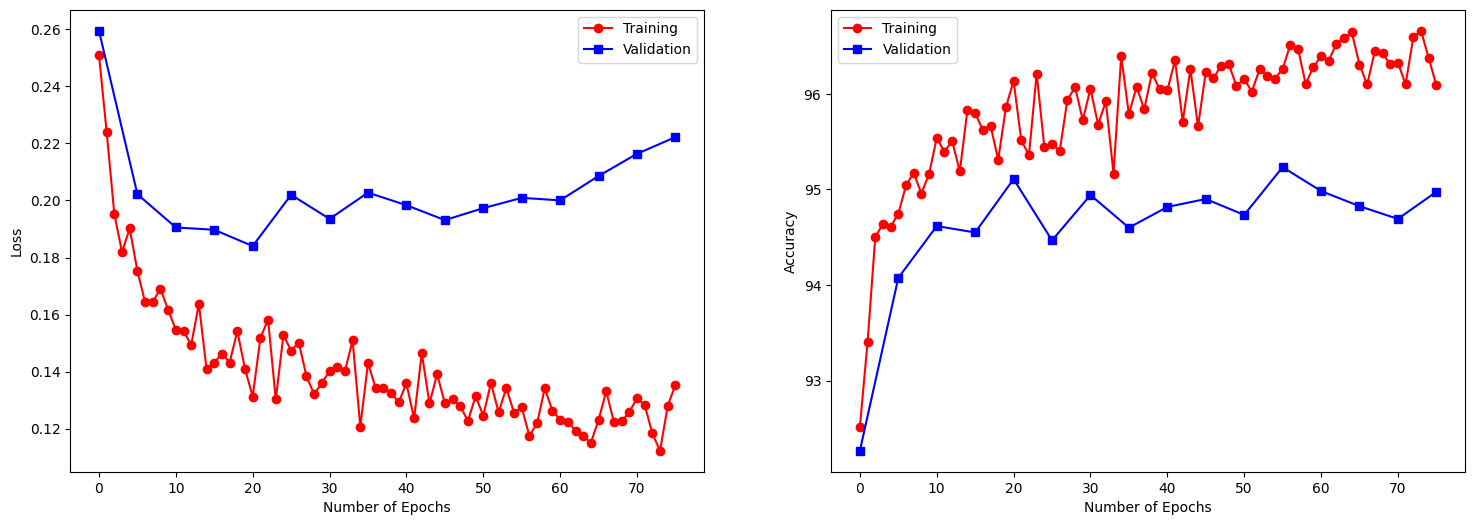

Epoch 76: training loss: 0.12044408864776293, accuracy: 96.41041666666666
Epoch 77: training loss: 0.12840669509768485, accuracy: 96.29166666666666
Epoch 78: training loss: 0.11837649685144425, accuracy: 96.77916666666667
Epoch 79: training loss: 0.11339775371054808, accuracy: 96.62291666666667
Epoch 80: training loss: 0.1103606345852216, accuracy: 96.67291666666667
Validation loss: 0.2018, validation accuracy: 95.13%


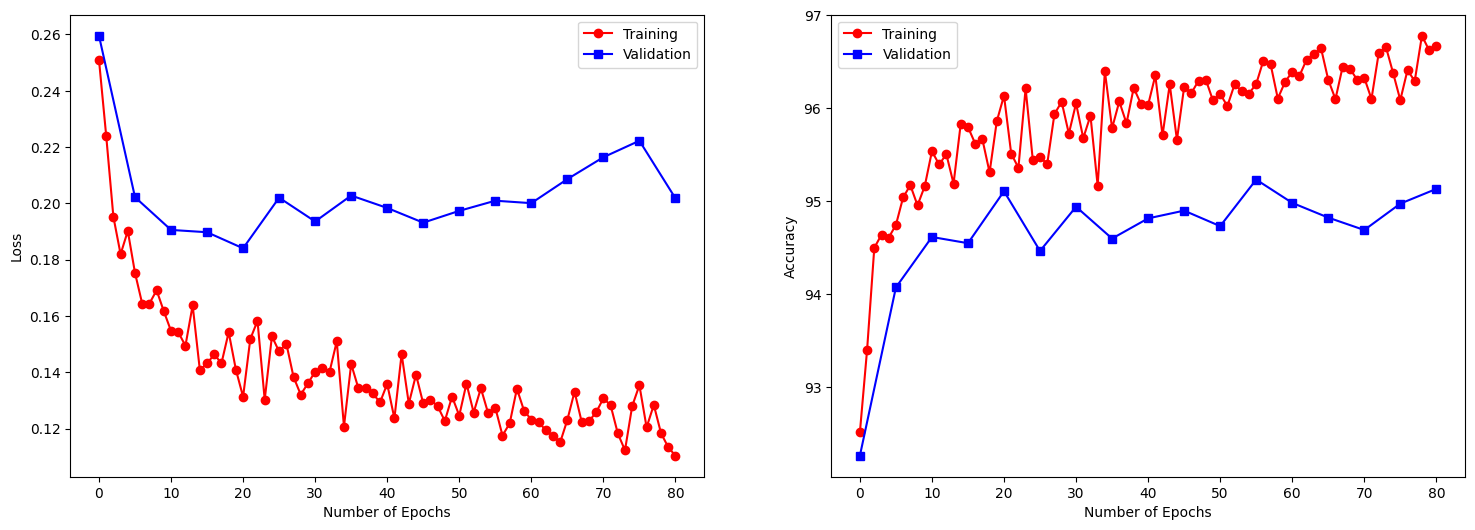

Epoch 81: training loss: 0.12455445003012816, accuracy: 96.29375
Epoch 82: training loss: 0.11075682956973712, accuracy: 96.72291666666666
Epoch 83: training loss: 0.1158697723497947, accuracy: 96.5875
Epoch 84: training loss: 0.11562868176897367, accuracy: 96.52916666666667
Epoch 85: training loss: 0.1241634814341863, accuracy: 96.33125
Validation loss: 0.2083, validation accuracy: 94.60%


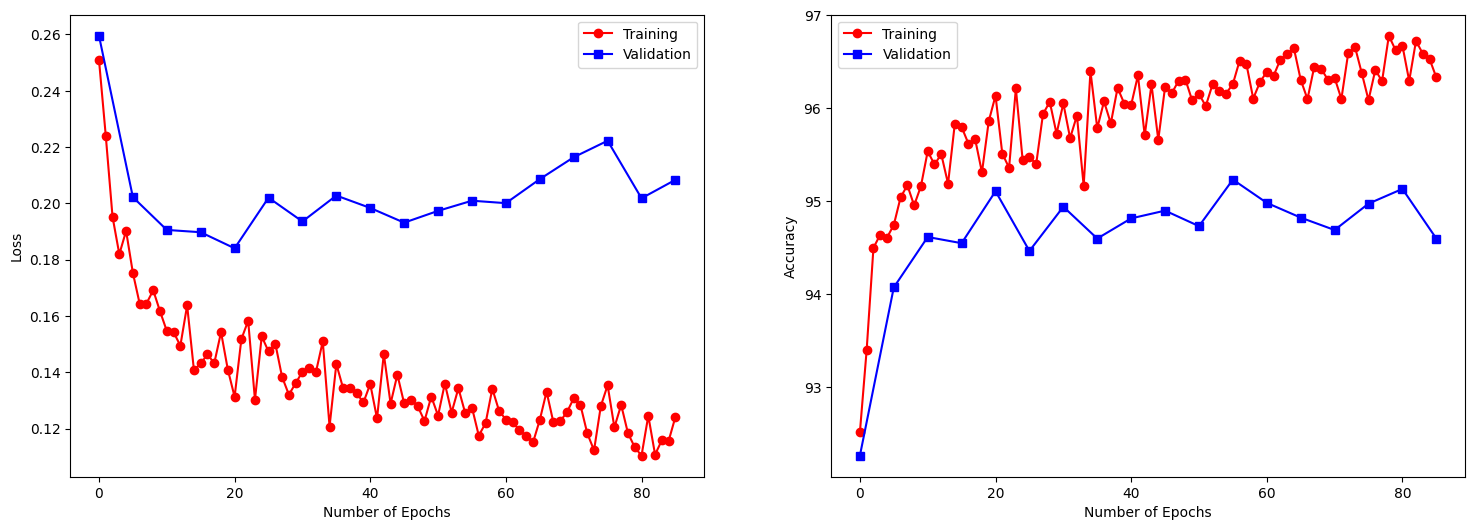

Epoch 86: training loss: 0.11470148120820522, accuracy: 96.62083333333334
Epoch 87: training loss: 0.1149911384532849, accuracy: 96.5
Epoch 88: training loss: 0.1092196039656798, accuracy: 96.62291666666667
Epoch 89: training loss: 0.11985266741613547, accuracy: 96.41458333333334
Epoch 90: training loss: 0.11980048508942127, accuracy: 96.37291666666667
Validation loss: 0.2007, validation accuracy: 95.09%


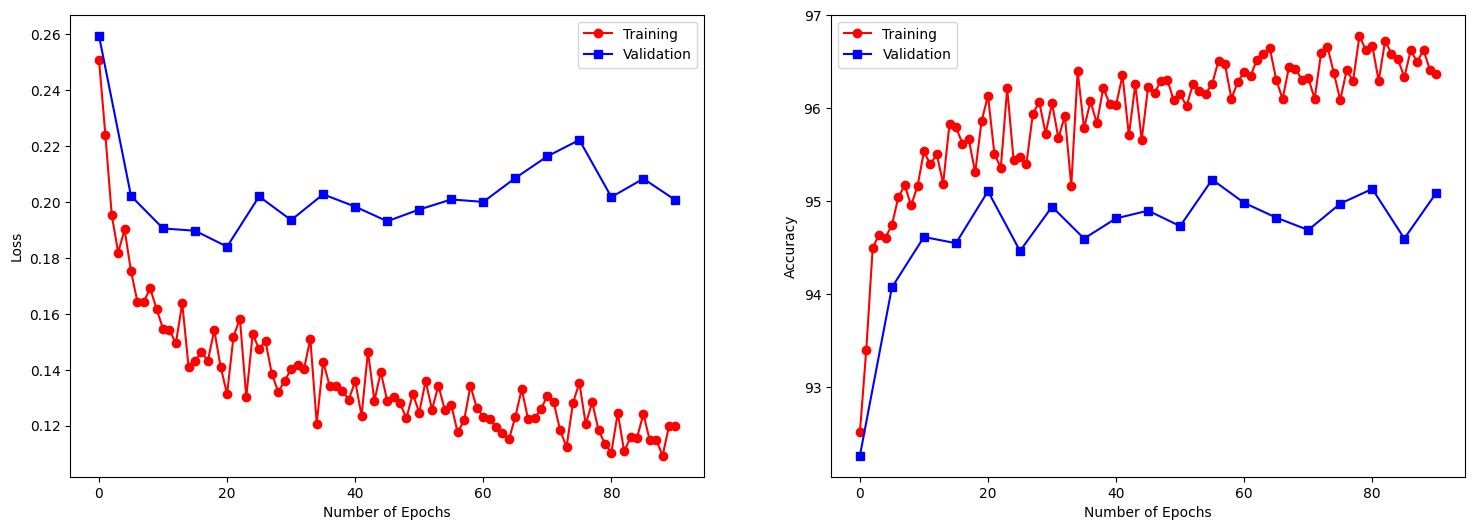

Epoch 91: training loss: 0.11917108966906866, accuracy: 96.49791666666667
Epoch 92: training loss: 0.11868848874668281, accuracy: 96.46875
Epoch 93: training loss: 0.13365941005945206, accuracy: 96.11666666666666
Epoch 94: training loss: 0.10992514378825824, accuracy: 96.73541666666667
Epoch 95: training loss: 0.11364733896652858, accuracy: 96.72291666666666
Validation loss: 0.2045, validation accuracy: 94.97%


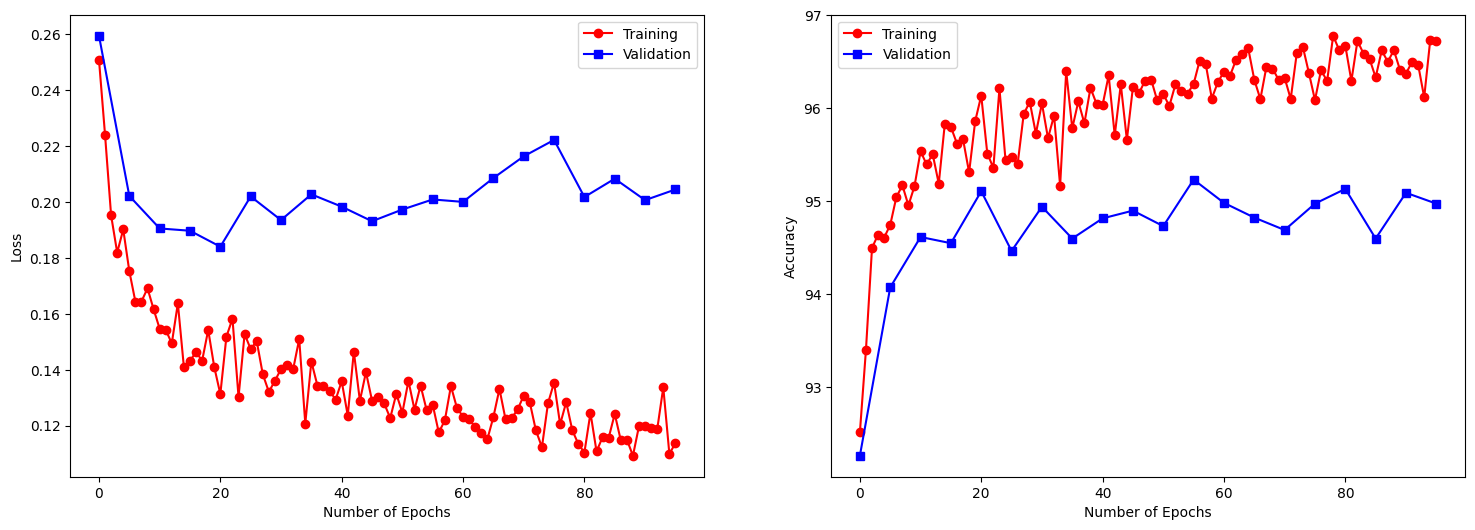

Epoch 96: training loss: 0.11553641144931316, accuracy: 96.7375
Epoch 97: training loss: 0.12052147782842318, accuracy: 96.45
Epoch 98: training loss: 0.1108383365124464, accuracy: 96.77916666666667
Epoch 99: training loss: 0.11822969485322635, accuracy: 96.5875
CPU times: user 6h 17min 56s, sys: 7min 42s, total: 6h 25min 38s
Wall time: 12min 3s


In [39]:
%%time

model = MyNonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_epoch_array = []
train_accuracy_array = []
train_loss_array = []
validation_epoch_array = []
validation_loss_array = []
validation_accuracy_array = []

epochs = 100
n_validations = 20
check_validation = epochs // n_validations
for j in range(epochs):
    train_one_epoch(train_dataloader, model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    train_epoch_array.append(j)
    train_accuracy_array.append(acc)
    train_loss_array.append(loss)
    
    if j % check_validation == 0:
        # do a validation check
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn)
        print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))
        validation_epoch_array.append(j)
        validation_loss_array.append(loss_val)
        validation_accuracy_array.append(acc_val)
    
        # update metrics plot
        fig, axes = plt.subplots(1, 2, figsize=(18,6), dpi=100)

        axes[0].plot(train_epoch_array, train_loss_array, 'or-', label='Training')
        axes[0].plot(validation_epoch_array, validation_loss_array, 'sb-', label='Validation')
        axes[0].set_xlabel('Number of Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()

        axes[1].plot(train_epoch_array, train_accuracy_array, 'or-', label='Training')
        axes[1].plot(validation_epoch_array, validation_accuracy_array, 'sb-', label='Validation')
        axes[1].set_xlabel('Number of Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()

        plt.show()

As the plots indicate, the model continues to drive the loss down (i.e., drive the accuracy up) for the majority of the 100 epochs. But, as we validate with data the model hasn't seen, we reach a point where the model is less accurate with the new, unseen data. This appears to be around 20 epochs. So, for the purposes of this data and this model, about 20 epochs seems to be the optimal number of passes over the data.

Let's retrian and test our model:

### Model Re-Training and Testing

Epoch 0: training loss: 0.24139460494120915, accuracy: 92.975
Epoch 1: training loss: 0.2023164680202802, accuracy: 93.90416666666667
Epoch 2: training loss: 0.19790953145424525, accuracy: 94.20625
Epoch 3: training loss: 0.18724713289737702, accuracy: 94.49791666666667
Epoch 4: training loss: 0.1749578575293223, accuracy: 94.67708333333333
Epoch 5: training loss: 0.16618381935358048, accuracy: 95.1875
Epoch 6: training loss: 0.17571950952212015, accuracy: 94.90416666666667
Epoch 7: training loss: 0.16507906198501587, accuracy: 95.20833333333333
Epoch 8: training loss: 0.16569833171367646, accuracy: 95.33541666666666
Epoch 9: training loss: 0.16680469063917797, accuracy: 95.34166666666667
Epoch 10: training loss: 0.1670046281615893, accuracy: 94.9125
Epoch 11: training loss: 0.13672647615273795, accuracy: 95.97083333333333
Epoch 12: training loss: 0.15845519535740216, accuracy: 95.5125
Epoch 13: training loss: 0.15696726062893868, accuracy: 95.37708333333333
Epoch 14: training loss: 0.

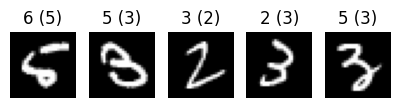

In [40]:
%%time

model = MyNonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_epoch_array = []
train_accuracy_array = []
train_loss_array = []

epochs = 20
for j in range(epochs):
    train_one_epoch(train_dataloader, model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
# evaluate the model with test data
acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_test, acc_test))

# show model failures
show_failures(model, test_dataloader)

As indicated above, our non-linear model gets an accuracy of about 94.5%.